In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)


In [10]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

In [3]:
input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Input data shape:", input_data.shape)
print("Target shape:", target.shape)
print("Dates length:", len(dates))

# Simple check that time dimension matches
assert input_data.shape[0] == target.shape[0] == len(dates)

# Global mean dose over all grid points (axis=1 along space)
dose_global_mean = target.mean(axis=1)

# Build DataFrame: 12 neutron monitors + global mean dose
nm_cols = [f"NM{i+1}" for i in range(input_data.shape[1])]  # rename if you have real station names
df = pd.DataFrame(
    data=np.concatenate([input_data, dose_global_mean[:, None]], axis=1),
    index=dates,
    columns=nm_cols + ["dose_global_mean"]
)

df.index.name = "date"
print(df.head())


Input data shape: (8400, 12)
Target shape: (8400, 65341)
Dates length: 8400
               NM1      NM2     NM3         NM4     NM5      NM6      NM7  \
date                                                                        
2001-01-01  51.496  146.925  89.674  200.119000  96.691  156.946  190.858   
2001-01-02  51.208  146.207  89.685  199.936822  96.471  156.521  190.510   
2001-01-03  51.177  146.661  89.532  199.776000  96.406  156.292  190.067   
2001-01-04  51.118  146.416  89.454  199.638000  96.690  156.800  190.353   
2001-01-05  51.271  146.159  89.096  199.863000  96.718  156.746  190.217   

                NM8      NM9     NM10     NM11     NM12  dose_global_mean  
date                                                                       
2001-01-01  173.584  189.937  112.334  263.335  105.907          0.032805  
2001-01-02  173.487  189.465  111.865  260.803  104.626          0.032706  
2001-01-03  173.161  190.388  111.574  260.519  104.769          0.032706  
2001

In [16]:
# 1) Remove slow trend with a 365-day rolling mean
trend = df["dose_global_mean"].rolling(365, center=True, min_periods=180).mean()
anom = df["dose_global_mean"] - trend

anom_df = anom.to_frame("anom").dropna().reset_index()
anom_df["doy"] = anom_df["date"].dt.dayofyear

# Drop Feb 29 to avoid mixing 365/366 days
anom_df = anom_df[~((anom_df["date"].dt.month == 2) & (anom_df["date"].dt.day == 29))]

# 2) Climatological annual cycle: mean anomaly for each day-of-year
clim = anom_df.groupby("doy")["anom"].mean()


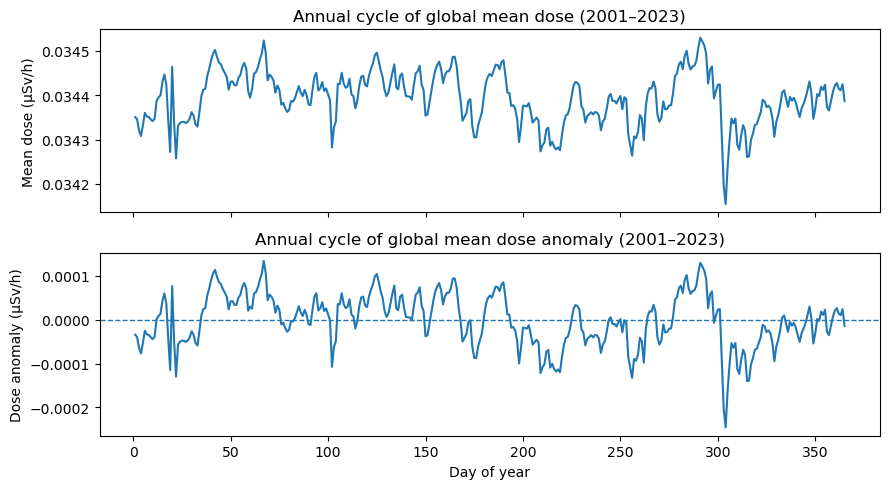

In [19]:
# ---------- 1) Climatological mean (raw dose) ----------
df_mean = df.copy()
# drop Feb 29
df_mean = df_mean[~((df_mean.index.month == 2) & (df_mean.index.day == 29))]
df_mean["doy"] = df_mean.index.dayofyear

clim_mean = df_mean.groupby("doy")["dose_global_mean"].mean()
# drop day 366 to avoid the noisy tail
clim_mean = clim_mean[clim_mean.index <= 365]

# ---------- 2) Climatological anomaly ----------
anom_df = anom.to_frame("anom").dropna().reset_index()
anom_df = anom_df[~((anom_df["date"].dt.month == 2) & (anom_df["date"].dt.day == 29))]
anom_df["doy"] = anom_df["date"].dt.dayofyear

clim_anom = anom_df.groupby("doy")["anom"].mean()
clim_anom = clim_anom[clim_anom.index <= 365]

# ---------- 3) Plot ----------
fig, axes = plt.subplots(2, 1, figsize=(9, 5), sharex=True)

axes[0].plot(clim_mean.index, clim_mean.values)
axes[0].set_ylabel("Mean dose (µSv/h)")
axes[0].set_title("Annual cycle of global mean dose (2001–2023)")

axes[1].plot(clim_anom.index, clim_anom.values)
axes[1].axhline(0.0, linestyle="--", linewidth=1)
axes[1].set_xlabel("Day of year")
axes[1].set_ylabel("Dose anomaly (µSv/h)")
axes[1].set_title("Annual cycle of global mean dose anomaly (2001–2023)")

plt.tight_layout()
plt.savefig("analysis/seasonality/figures/annual_cycle_dose_and_anomaly.png", dpi=300)
plt.show()


<Figure size 600x300 with 0 Axes>

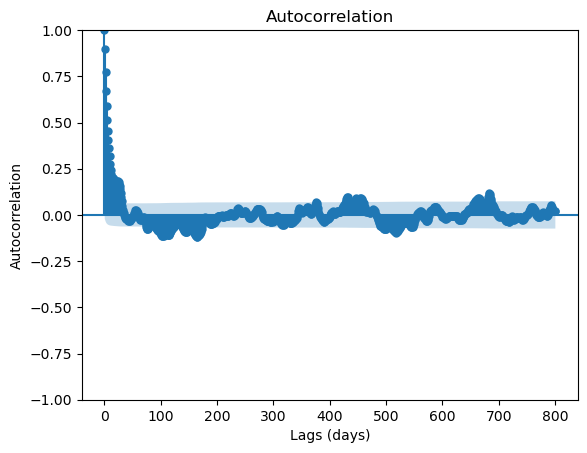

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(6, 3))
plot_acf(anom.dropna(), lags=800)
plt.xlabel("Lags (days)")
plt.ylabel("Autocorrelation")
plt.savefig("analysis/seasonality/figures/acf_dose_anomaly.png", dpi=300)
plt.show()
